# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
## Your code here
from collections import Counter
import random

'''
threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
'''

threshold = 1e-5
#calculate the probability
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1-np.sqrt(threshold/freqs[word]) for word in word_counts}

#scroll through the entire into words our data set
#drop words that are frequent

#train_words = [word for word in int_words if p_drop[word] < random.random()] 
#samples from uniform distribution from zero to one or we can 
train_words = [word for word in int_words if random.random() < (1-p_drop[word])] #another way

print("train_words: {}".format(len(train_words)))

train_words: 4627296


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    #generate random window
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx-R) > 0 else 0
    stop = idx+R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size #(mod)
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:
n_vocab = len(int_to_vocab)
n_embedding =  200# Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))# create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))# create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab))# create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss (softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

하위 디렉터리 또는 파일 checkpoints이(가) 이미 있습니다.


In [14]:
#Version Check
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [15]:
epochs = 60
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/60 Iteration: 100 Avg. Training loss: 5.6667 0.0232 sec/batch
Epoch 1/60 Iteration: 200 Avg. Training loss: 5.5879 0.0213 sec/batch
Epoch 1/60 Iteration: 300 Avg. Training loss: 5.5045 0.0218 sec/batch
Epoch 1/60 Iteration: 400 Avg. Training loss: 5.6104 0.0212 sec/batch
Epoch 1/60 Iteration: 500 Avg. Training loss: 5.5130 0.0210 sec/batch
Epoch 1/60 Iteration: 600 Avg. Training loss: 5.5358 0.0213 sec/batch
Epoch 1/60 Iteration: 700 Avg. Training loss: 5.5220 0.0210 sec/batch
Epoch 1/60 Iteration: 800 Avg. Training loss: 5.5438 0.0213 sec/batch
Epoch 1/60 Iteration: 900 Avg. Training loss: 5.4818 0.0214 sec/batch
Epoch 1/60 Iteration: 1000 Avg. Training loss: 5.4507 0.0212 sec/batch
Nearest to on: car, carrot, mamadou, malleability, filmfour, dearborn, rained, capture,
Nearest to five: outweighed, arkady, consultants, regurgitated, clarinetists, node, solander, purcell,
Nearest to world: telephoned, channing, unarmed, mishandling, buses, tasker, folie, switzerland,
Nearest to 

Nearest to joseph: castillian, wieser, nna, decay, hamilton, ische, covenant, cohesive,
Nearest to centre: shawl, pictish, argentine, silvery, utc, gilmore, gilberto, situations,
Nearest to shows: mates, perfected, logarithms, snare, flavors, erwin, fusion, pantheon,
Nearest to writers: asquith, launched, exemplified, but, erubin, lastnode, supplying, vint,
Nearest to defense: proceedings, brash, conducive, residential, blount, sojourns, polytechnique, commissioning,
Nearest to nobel: diplomat, george, ruggiero, synthesizing, crabs, constructions, distilled, casio,
Epoch 1/60 Iteration: 4100 Avg. Training loss: 4.6796 0.0221 sec/batch
Epoch 1/60 Iteration: 4200 Avg. Training loss: 4.6444 0.0213 sec/batch
Epoch 1/60 Iteration: 4300 Avg. Training loss: 4.6301 0.0216 sec/batch
Epoch 1/60 Iteration: 4400 Avg. Training loss: 4.6475 0.0216 sec/batch
Epoch 1/60 Iteration: 4500 Avg. Training loss: 4.6128 0.0217 sec/batch
Epoch 1/60 Iteration: 4600 Avg. Training loss: 4.6447 0.0217 sec/batch
Ep

Nearest to was: naval, kibbutz, cetera, ii, fun, father, punch, his,
Nearest to up: vaporization, easy, like, ridges, boom, scourge, ripe, brush,
Nearest to have: antipsychotic, martians, practised, amount, position, xinjiang, revolts, fallacy,
Nearest to when: heaven, quirin, misspelling, too, nicolai, vibrato, privatdozent, ignorance,
Nearest to know: doing, do, detection, historicism, tamarins, behaviorist, glad, publish,
Nearest to units: speed, reductions, inhalation, plain, amongst, beryllium, kingfisher, tanning,
Nearest to joseph: wieser, castillian, gunter, ibu, britanniae, nna, beth, trombonist,
Nearest to centre: argentine, grudgingly, shawl, archons, gilmore, utc, antofagasta, silvery,
Nearest to shows: fruity, perfected, mates, flavors, drawers, thracians, fusion, snare,
Nearest to writers: lastnode, exemplified, mathematicians, erubin, vitebsk, asquith, moralist, stile,
Nearest to defense: proceedings, residential, storming, brash, conducive, rights, blount, gen,
Nearest 

Epoch 3/60 Iteration: 11900 Avg. Training loss: 4.1575 0.0215 sec/batch
Epoch 3/60 Iteration: 12000 Avg. Training loss: 4.1807 0.0215 sec/batch
Nearest to on: capture, hieroglyphica, rained, boingo, redistribution, mamadou, profile, vertebra,
Nearest to five: two, one, four, zero, three, eight, purcell, seven,
Nearest to world: switzerland, ambit, tasker, folie, ceau, unarmed, gubbio, mishandling,
Nearest to eight: one, four, zero, five, six, nine, rolland, two,
Nearest to was: kibbutz, ii, naval, his, parthia, northamptonshire, punch, moved,
Nearest to up: vaporization, easy, ripe, injunction, alright, scourge, boom, pommel,
Nearest to have: antipsychotic, martians, revolts, statistical, plurals, practised, cramer, underlining,
Nearest to when: quirin, heaven, reacquired, levied, too, misspelling, drive, cote,
Nearest to know: doing, do, detection, tamarins, historicism, glad, you, mirror,
Nearest to units: reductions, speed, tanning, beryllium, unit, battalions, per, anselme,
Nearest

Epoch 4/60 Iteration: 15200 Avg. Training loss: 4.0614 0.0215 sec/batch
Epoch 4/60 Iteration: 15300 Avg. Training loss: 4.0277 0.0216 sec/batch
Epoch 4/60 Iteration: 15400 Avg. Training loss: 4.0469 0.0215 sec/batch
Epoch 4/60 Iteration: 15500 Avg. Training loss: 4.0619 0.0213 sec/batch
Epoch 4/60 Iteration: 15600 Avg. Training loss: 4.0794 0.0213 sec/batch
Epoch 4/60 Iteration: 15700 Avg. Training loss: 4.0592 0.0212 sec/batch
Epoch 4/60 Iteration: 15800 Avg. Training loss: 4.0827 0.0214 sec/batch
Epoch 4/60 Iteration: 15900 Avg. Training loss: 4.0524 0.0214 sec/batch
Epoch 4/60 Iteration: 16000 Avg. Training loss: 4.0336 0.0211 sec/batch
Nearest to on: rained, hieroglyphica, walken, mamadou, profile, capture, undated, boingo,
Nearest to five: two, one, four, zero, three, eight, six, seven,
Nearest to world: ambit, switzerland, qualitative, folie, tasker, ceau, gubbio, mishandling,
Nearest to eight: one, four, zero, six, five, two, nine, three,
Nearest to was: his, moved, younger, kib

Nearest to shows: fruity, drawers, sternum, logarithms, snare, flavors, fusion, whitewater,
Nearest to writers: novelists, mathematicians, fellows, amuse, horror, erubin, mineralogical, mawlana,
Nearest to defense: withstanding, warheads, detain, proceedings, paralyzing, hijack, telic, alford,
Nearest to nobel: recipient, ruggiero, physiology, prize, physicist, laureate, conductor, distilled,
Epoch 5/60 Iteration: 19100 Avg. Training loss: 3.9913 0.0224 sec/batch
Epoch 5/60 Iteration: 19200 Avg. Training loss: 3.9535 0.0210 sec/batch
Epoch 5/60 Iteration: 19300 Avg. Training loss: 4.0285 0.0210 sec/batch
Epoch 5/60 Iteration: 19400 Avg. Training loss: 4.0325 0.0210 sec/batch
Epoch 5/60 Iteration: 19500 Avg. Training loss: 4.0466 0.0215 sec/batch
Epoch 5/60 Iteration: 19600 Avg. Training loss: 3.9856 0.0211 sec/batch
Epoch 5/60 Iteration: 19700 Avg. Training loss: 3.9101 0.0213 sec/batch
Epoch 5/60 Iteration: 19800 Avg. Training loss: 3.9442 0.0211 sec/batch
Epoch 5/60 Iteration: 19900 

Nearest to know: doing, do, you, reply, glad, evoking, if, furor,
Nearest to units: unit, battalions, per, residing, makeup, density, anselme, dared,
Nearest to joseph: wieser, gunter, ibu, nna, coombe, herman, decay, ward,
Nearest to centre: piran, gilmore, sporting, renovation, dundas, building, southbound, dermanland,
Nearest to shows: fruity, drawers, sternum, resumption, logarithms, whitewater, handful, snare,
Nearest to writers: novelists, mathematicians, fellows, horror, amuse, launched, mineralogical, erubin,
Nearest to defense: paralyzing, detain, withstanding, warheads, polytechnique, proceedings, hazara, soundness,
Nearest to nobel: recipient, prize, physiology, ruggiero, laureate, physicist, medicine, distilled,
Epoch 5/60 Iteration: 23100 Avg. Training loss: 4.0103 0.0220 sec/batch
Epoch 6/60 Iteration: 23200 Avg. Training loss: 3.9871 0.0138 sec/batch
Epoch 6/60 Iteration: 23300 Avg. Training loss: 3.9599 0.0211 sec/batch
Epoch 6/60 Iteration: 23400 Avg. Training loss: 3.

Nearest to up: pommel, easy, alright, injunction, pilgrimage, handily, stormed, optional,
Nearest to have: appearances, bogdanovich, antipsychotic, no, cramer, practised, martians, revolts,
Nearest to when: quirin, leave, levied, reacquired, at, chose, olwen, drive,
Nearest to know: doing, you, do, transfusions, reply, glad, scared, if,
Nearest to units: unit, battalions, residing, per, makeup, dared, density, anselme,
Nearest to joseph: wieser, ibu, coombe, nna, gunter, herman, decay, ward,
Nearest to centre: piran, renovation, dundas, naturalizing, katarina, dermanland, antofagasta, sporting,
Nearest to shows: fruity, sternum, logarithms, handful, nc, whitewater, campy, flavors,
Nearest to writers: novelists, mathematicians, fellows, authors, horror, amuse, recipients, polymaths,
Nearest to defense: paralyzing, warheads, withstanding, detain, polytechnique, soundness, hazara, department,
Nearest to nobel: recipient, prize, physiology, laureate, medicine, ruggiero, physicist, distille

Nearest to world: germany, ambit, stormbringer, qualitative, history, switzerland, accelerating, boast,
Nearest to eight: one, four, zero, six, five, three, two, nine,
Nearest to was: had, were, became, first, his, the, he, been,
Nearest to up: pommel, alright, optional, stripped, easy, seder, injunction, krs,
Nearest to have: appearances, no, antipsychotic, serena, bogdanovich, martians, closest, cramer,
Nearest to when: quirin, because, with, levied, leave, reacquired, drive, heaven,
Nearest to know: doing, you, do, glad, reply, what, transfusions, if,
Nearest to units: unit, battalions, makeup, per, residing, dared, rank, hellespont,
Nearest to joseph: coombe, wieser, nna, ibu, decay, cohesive, herman, gunter,
Nearest to centre: renovation, sporting, piran, katarina, dundas, dermanland, naturalizing, seaton,
Nearest to shows: fruity, handful, logarithms, campy, namesake, whitewater, encarta, resumption,
Nearest to writers: novelists, mathematicians, authors, fellows, horror, amuse, 

Nearest to world: germany, stormbringer, ambit, collegium, qualitative, boast, disdain, history,
Nearest to eight: one, four, zero, six, five, two, three, nine,
Nearest to was: had, became, were, first, the, been, his, he,
Nearest to up: easy, optional, into, waveform, kiss, seder, stripped, krs,
Nearest to have: no, appearances, there, most, cramer, had, obrador, antipsychotic,
Nearest to when: because, levied, quirin, leave, pel, with, at, on,
Nearest to know: doing, you, do, glad, if, what, reply, not,
Nearest to units: unit, battalions, per, makeup, dared, kilogram, resigning, residing,
Nearest to joseph: coombe, wieser, ibu, nna, herman, generic, gunter, krishnamurti,
Nearest to centre: renovation, piran, katarina, naturalizing, sporting, dundas, tiergarten, charon,
Nearest to shows: fruity, handful, nc, flavors, resumption, ephemeris, in, dancesport,
Nearest to writers: novelists, mathematicians, authors, fellows, horror, launched, recipients, amuse,
Nearest to defense: withstand

Nearest to eight: one, four, six, three, zero, two, nine, five,
Nearest to was: had, became, were, first, been, he, his, the,
Nearest to up: rusty, into, easy, optional, krs, seder, pommel, at,
Nearest to have: no, there, are, had, appearances, bogdanovich, their, practised,
Nearest to when: leave, before, with, because, quirin, on, in, levied,
Nearest to know: doing, you, do, glad, if, what, reply, we,
Nearest to units: unit, battalions, per, makeup, resigning, kilogram, residing, rank,
Nearest to joseph: coombe, wieser, generic, ibu, herman, burundi, nna, exile,
Nearest to centre: renovation, naturalizing, piran, katarina, sporting, audit, charon, antofagasta,
Nearest to shows: fruity, nc, handful, ephemeris, dancesport, whitewater, antonioni, sternum,
Nearest to writers: novelists, mathematicians, authors, fellows, horror, recipients, polymaths, winners,
Nearest to defense: withstanding, defensive, soundness, paralyzing, warheads, detain, defence, alford,
Nearest to nobel: prize, re

Nearest to was: had, became, first, been, were, later, he, his,
Nearest to up: at, that, into, easy, started, with, stormed, optional,
Nearest to have: no, there, are, had, that, most, their, larger,
Nearest to when: because, with, before, in, on, at, leave, quirin,
Nearest to know: doing, you, do, what, if, glad, reply, we,
Nearest to units: unit, per, battalions, makeup, rank, goggles, kilogram, residing,
Nearest to joseph: coombe, generic, burundi, ibu, nna, wieser, hasdai, herman,
Nearest to centre: renovation, sporting, katarina, tiergarten, piran, charon, naturalizing, parliament,
Nearest to shows: handful, fruity, nc, dancesport, antonioni, show, ephemeris, whitewater,
Nearest to writers: novelists, authors, mathematicians, fellows, winners, proteg, recipients, seattleites,
Nearest to defense: defensive, withstanding, warheads, soundness, paralyzing, tenet, detain, defence,
Nearest to nobel: prize, recipient, laureate, peace, prizes, physiology, ruggiero, physicist,
Epoch 10/60 

Nearest to when: before, in, with, on, because, and, he, was,
Nearest to know: doing, you, glad, what, if, okay, do, we,
Nearest to units: unit, per, battalions, makeup, pint, goggles, dared, kilogram,
Nearest to joseph: coombe, generic, burundi, exile, ibu, herman, hasdai, wieser,
Nearest to centre: katarina, piran, parliament, tiergarten, boyne, sporting, renovation, charon,
Nearest to shows: handful, fruity, nc, prehistoric, ephemeris, goes, dancesport, show,
Nearest to writers: novelists, authors, mathematicians, fellows, winners, births, proteg, recipients,
Nearest to defense: defensive, warheads, withstanding, soundness, paralyzing, hazara, defence, mukti,
Nearest to nobel: prize, recipient, laureate, physiology, peace, prizes, ruggiero, physicist,
Epoch 11/60 Iteration: 47100 Avg. Training loss: 3.8589 0.0221 sec/batch
Epoch 11/60 Iteration: 47200 Avg. Training loss: 3.8059 0.0212 sec/batch
Epoch 11/60 Iteration: 47300 Avg. Training loss: 3.8732 0.0212 sec/batch
Epoch 11/60 Iter

Nearest to centre: piran, sporting, lobby, katarina, naturalizing, parliament, boyne, renovation,
Nearest to shows: handful, fruity, show, prehistoric, antonioni, goes, nc, dancesport,
Nearest to writers: novelists, authors, mathematicians, fellows, winners, philosophers, proteg, recipients,
Nearest to defense: defensive, defence, withstanding, paralyzing, detain, tenet, soundness, warheads,
Nearest to nobel: prize, recipient, laureate, physiology, peace, physicist, ruggiero, awarded,
Epoch 12/60 Iteration: 51100 Avg. Training loss: 3.8147 0.0222 sec/batch
Epoch 12/60 Iteration: 51200 Avg. Training loss: 3.7729 0.0214 sec/batch
Epoch 12/60 Iteration: 51300 Avg. Training loss: 3.8564 0.0214 sec/batch
Epoch 12/60 Iteration: 51400 Avg. Training loss: 3.7759 0.0211 sec/batch
Epoch 12/60 Iteration: 51500 Avg. Training loss: 3.7919 0.0216 sec/batch
Epoch 12/60 Iteration: 51600 Avg. Training loss: 3.7699 0.0209 sec/batch
Epoch 12/60 Iteration: 51700 Avg. Training loss: 3.8338 0.0210 sec/batch

Nearest to writers: novelists, authors, mathematicians, fellows, winners, philosophers, fiction, recipients,
Nearest to defense: defence, paralyzing, defensive, warheads, detain, withstanding, mythe, tenet,
Nearest to nobel: prize, recipient, laureate, physiology, peace, medicine, prizes, physicist,
Epoch 12/60 Iteration: 55100 Avg. Training loss: 3.7735 0.0221 sec/batch
Epoch 12/60 Iteration: 55200 Avg. Training loss: 3.7834 0.0211 sec/batch
Epoch 12/60 Iteration: 55300 Avg. Training loss: 3.8446 0.0210 sec/batch
Epoch 12/60 Iteration: 55400 Avg. Training loss: 3.8151 0.0211 sec/batch
Epoch 12/60 Iteration: 55500 Avg. Training loss: 3.8290 0.0213 sec/batch
Epoch 13/60 Iteration: 55600 Avg. Training loss: 3.7986 0.0159 sec/batch
Epoch 13/60 Iteration: 55700 Avg. Training loss: 3.8320 0.0215 sec/batch
Epoch 13/60 Iteration: 55800 Avg. Training loss: 3.7725 0.0214 sec/batch
Epoch 13/60 Iteration: 55900 Avg. Training loss: 3.8310 0.0213 sec/batch
Epoch 13/60 Iteration: 56000 Avg. Training

Nearest to nobel: prize, recipient, laureate, peace, physiology, prizes, awarded, award,
Epoch 13/60 Iteration: 59100 Avg. Training loss: 3.7763 0.0223 sec/batch
Epoch 13/60 Iteration: 59200 Avg. Training loss: 3.9047 0.0214 sec/batch
Epoch 13/60 Iteration: 59300 Avg. Training loss: 3.8593 0.0210 sec/batch
Epoch 13/60 Iteration: 59400 Avg. Training loss: 3.8310 0.0209 sec/batch
Epoch 13/60 Iteration: 59500 Avg. Training loss: 3.7519 0.0214 sec/batch
Epoch 13/60 Iteration: 59600 Avg. Training loss: 3.7269 0.0211 sec/batch
Epoch 13/60 Iteration: 59700 Avg. Training loss: 3.8099 0.0212 sec/batch
Epoch 13/60 Iteration: 59800 Avg. Training loss: 3.7449 0.0215 sec/batch
Epoch 13/60 Iteration: 59900 Avg. Training loss: 3.8197 0.0216 sec/batch
Epoch 13/60 Iteration: 60000 Avg. Training loss: 3.7752 0.0211 sec/batch
Nearest to on: of, to, in, the, with, a, and, from,
Nearest to five: two, zero, four, three, one, six, eight, seven,
Nearest to world: germany, history, ambit, invincible, nine, sto

Epoch 14/60 Iteration: 63300 Avg. Training loss: 3.8044 0.0212 sec/batch
Epoch 14/60 Iteration: 63400 Avg. Training loss: 3.7697 0.0210 sec/batch
Epoch 14/60 Iteration: 63500 Avg. Training loss: 3.7748 0.0212 sec/batch
Epoch 14/60 Iteration: 63600 Avg. Training loss: 3.8016 0.0211 sec/batch
Epoch 14/60 Iteration: 63700 Avg. Training loss: 3.7420 0.0213 sec/batch
Epoch 14/60 Iteration: 63800 Avg. Training loss: 3.8412 0.0217 sec/batch
Epoch 14/60 Iteration: 63900 Avg. Training loss: 3.8728 0.0212 sec/batch
Epoch 14/60 Iteration: 64000 Avg. Training loss: 3.8334 0.0213 sec/batch
Nearest to on: of, in, the, with, when, and, to, from,
Nearest to five: two, four, zero, three, one, six, seven, eight,
Nearest to world: germany, history, ambit, invincible, archons, of, continents, stormbringer,
Nearest to eight: one, four, six, seven, three, two, five, nine,
Nearest to was: had, became, he, the, first, in, been, later,
Nearest to up: with, after, the, at, into, started, that, later,
Nearest to

Epoch 15/60 Iteration: 67600 Avg. Training loss: 3.7719 0.0211 sec/batch
Epoch 15/60 Iteration: 67700 Avg. Training loss: 3.7670 0.0212 sec/batch
Epoch 15/60 Iteration: 67800 Avg. Training loss: 3.8082 0.0213 sec/batch
Epoch 15/60 Iteration: 67900 Avg. Training loss: 3.7505 0.0216 sec/batch
Epoch 15/60 Iteration: 68000 Avg. Training loss: 3.7580 0.0215 sec/batch
Nearest to on: of, in, the, with, to, and, as, when,
Nearest to five: two, four, zero, three, one, six, seven, eight,
Nearest to world: germany, history, ambit, wadb, stormbringer, countries, archons, boast,
Nearest to eight: one, four, seven, six, three, two, five, nine,
Nearest to was: had, became, later, the, he, first, in, been,
Nearest to up: with, that, the, two, at, to, when, into,
Nearest to have: are, there, been, and, exist, their, only, other,
Nearest to when: with, in, on, before, because, that, to, of,
Nearest to know: you, what, doing, we, i, don, do, glad,
Nearest to units: unit, battalions, makeup, per, comparis

Epoch 16/60 Iteration: 72000 Avg. Training loss: 3.7989 0.0213 sec/batch
Nearest to on: in, of, the, with, as, a, to, and,
Nearest to five: four, two, zero, three, one, seven, six, eight,
Nearest to world: germany, history, ambit, wadb, nine, invincible, countries, kabuki,
Nearest to eight: one, six, seven, four, nine, three, five, zero,
Nearest to was: had, became, later, been, the, were, first, he,
Nearest to up: two, with, into, four, out, the, thanks, started,
Nearest to have: there, are, been, exist, and, other, these, only,
Nearest to when: before, in, because, on, with, after, to, is,
Nearest to know: what, you, doing, we, i, do, don, if,
Nearest to units: unit, battalions, per, comparison, makeup, pint, rank, dyne,
Nearest to joseph: exile, cowdery, generic, burundi, kadena, ventspils, coombe, kessler,
Nearest to centre: programme, workforce, depends, disciplining, awful, antofagasta, centres, sukhothai,
Nearest to shows: show, shown, prehistoric, peptidoglycan, in, recitations

Nearest to eight: one, six, seven, four, three, five, two, nine,
Nearest to was: had, became, been, first, were, in, later, after,
Nearest to up: with, two, again, started, out, four, then, at,
Nearest to have: are, there, no, exist, other, been, these, their,
Nearest to when: in, before, with, because, but, leave, on, after,
Nearest to know: doing, what, you, we, i, don, do, if,
Nearest to units: unit, battalions, per, comparison, pint, makeup, rank, goggles,
Nearest to joseph: cowdery, exile, burundi, generic, etcetera, ventspils, kadena, cement,
Nearest to centre: centres, workforce, disciplining, awful, programme, dev, depends, piran,
Nearest to shows: show, shown, peptidoglycan, aired, prehistoric, recitations, goes, in,
Nearest to writers: novelists, authors, fellows, philosophers, mathematicians, winners, births, proteg,
Nearest to defense: defence, defensive, brigades, sdi, vitoria, operational, paralyzing, globalsecurity,
Nearest to nobel: prize, recipient, laureate, peace, pr

Nearest to when: in, with, before, is, an, because, the, a,
Nearest to know: what, doing, we, you, i, don, way, if,
Nearest to units: unit, battalions, per, comparison, pint, approximately, rank, brigade,
Nearest to joseph: cowdery, generic, exile, kirtland, define, kadena, essential, herman,
Nearest to centre: centres, awful, depends, antofagasta, workforce, disciplining, warehouses, programme,
Nearest to shows: show, shown, peptidoglycan, recitations, airs, viewers, banacek, gents,
Nearest to writers: authors, novelists, fellows, philosophers, winners, mathematicians, fiction, births,
Nearest to defense: defence, defensive, vitoria, linemen, brigades, operational, kicking, downing,
Nearest to nobel: prize, recipient, laureate, peace, physiology, prizes, awarded, physicist,
Epoch 18/60 Iteration: 80100 Avg. Training loss: 3.6592 0.0219 sec/batch
Epoch 18/60 Iteration: 80200 Avg. Training loss: 3.7270 0.0211 sec/batch
Epoch 18/60 Iteration: 80300 Avg. Training loss: 3.7540 0.0208 sec/b

Nearest to centre: centres, depends, disciplining, antofagasta, awful, warehouses, deansgate, cbt,
Nearest to shows: show, shown, viewers, recitations, prehistoric, airs, banacek, presenting,
Nearest to writers: authors, novelists, philosophers, winners, fellows, fiction, journalists, mathematicians,
Nearest to defense: defence, defensive, facility, brigades, operational, downing, offense, withstanding,
Nearest to nobel: prize, recipient, laureate, physiology, peace, prizes, physicist, awarded,
Epoch 19/60 Iteration: 84100 Avg. Training loss: 3.7366 0.0219 sec/batch
Epoch 19/60 Iteration: 84200 Avg. Training loss: 3.7530 0.0212 sec/batch
Epoch 19/60 Iteration: 84300 Avg. Training loss: 3.7862 0.0213 sec/batch
Epoch 19/60 Iteration: 84400 Avg. Training loss: 3.7141 0.0214 sec/batch
Epoch 19/60 Iteration: 84500 Avg. Training loss: 3.6784 0.0212 sec/batch
Epoch 19/60 Iteration: 84600 Avg. Training loss: 3.7088 0.0217 sec/batch
Epoch 19/60 Iteration: 84700 Avg. Training loss: 3.6780 0.0213

Nearest to defense: defence, defensive, brigades, mythe, gestion, downing, vitoria, facility,
Nearest to nobel: prize, recipient, laureate, physiology, peace, prizes, physicist, awarded,
Epoch 20/60 Iteration: 88100 Avg. Training loss: 3.7541 0.0221 sec/batch
Epoch 20/60 Iteration: 88200 Avg. Training loss: 3.7208 0.0212 sec/batch
Epoch 20/60 Iteration: 88300 Avg. Training loss: 3.7938 0.0215 sec/batch
Epoch 20/60 Iteration: 88400 Avg. Training loss: 3.7071 0.0214 sec/batch
Epoch 20/60 Iteration: 88500 Avg. Training loss: 3.7409 0.0215 sec/batch
Epoch 20/60 Iteration: 88600 Avg. Training loss: 3.6875 0.0211 sec/batch
Epoch 20/60 Iteration: 88700 Avg. Training loss: 3.7448 0.0210 sec/batch
Epoch 20/60 Iteration: 88800 Avg. Training loss: 3.7658 0.0215 sec/batch
Epoch 20/60 Iteration: 88900 Avg. Training loss: 3.7893 0.0213 sec/batch
Epoch 20/60 Iteration: 89000 Avg. Training loss: 3.7733 0.0213 sec/batch
Nearest to on: the, of, to, with, as, in, and, a,
Nearest to five: four, two, three

Epoch 20/60 Iteration: 92200 Avg. Training loss: 3.6941 0.0214 sec/batch
Epoch 20/60 Iteration: 92300 Avg. Training loss: 3.7467 0.0214 sec/batch
Epoch 20/60 Iteration: 92400 Avg. Training loss: 3.6993 0.0212 sec/batch
Epoch 20/60 Iteration: 92500 Avg. Training loss: 3.7772 0.0210 sec/batch
Epoch 21/60 Iteration: 92600 Avg. Training loss: 3.7791 0.0127 sec/batch
Epoch 21/60 Iteration: 92700 Avg. Training loss: 3.7254 0.0214 sec/batch
Epoch 21/60 Iteration: 92800 Avg. Training loss: 3.7420 0.0213 sec/batch
Epoch 21/60 Iteration: 92900 Avg. Training loss: 3.7649 0.0214 sec/batch
Epoch 21/60 Iteration: 93000 Avg. Training loss: 3.7183 0.0211 sec/batch
Nearest to on: of, the, to, in, and, with, at, first,
Nearest to five: four, three, two, zero, six, one, seven, eight,
Nearest to world: germany, nine, ambit, second, history, countries, archons, invincible,
Nearest to eight: one, six, four, seven, three, nine, five, two,
Nearest to was: had, the, later, he, became, been, first, after,
Neare

Epoch 21/60 Iteration: 96600 Avg. Training loss: 3.6998 0.0211 sec/batch
Epoch 21/60 Iteration: 96700 Avg. Training loss: 3.7418 0.0212 sec/batch
Epoch 21/60 Iteration: 96800 Avg. Training loss: 3.6621 0.0213 sec/batch
Epoch 21/60 Iteration: 96900 Avg. Training loss: 3.7699 0.0210 sec/batch
Epoch 21/60 Iteration: 97000 Avg. Training loss: 3.7595 0.0211 sec/batch
Nearest to on: the, of, to, with, in, a, and, from,
Nearest to five: four, two, three, zero, one, six, seven, eight,
Nearest to world: germany, nine, archons, feldheim, collegium, ambit, history, countries,
Nearest to eight: one, seven, six, four, nine, three, five, two,
Nearest to was: had, became, in, the, a, first, he, been,
Nearest to up: and, that, several, at, the, again, with, into,
Nearest to have: are, there, some, other, been, and, has, also,
Nearest to when: because, before, in, the, an, first, a, it,
Nearest to know: what, we, you, i, don, how, doing, things,
Nearest to units: unit, per, pint, battalions, comparison

Epoch 22/60 Iteration: 100900 Avg. Training loss: 3.8156 0.0215 sec/batch
Epoch 22/60 Iteration: 101000 Avg. Training loss: 3.7774 0.0217 sec/batch
Nearest to on: of, the, with, a, in, and, at, also,
Nearest to five: four, zero, three, two, one, six, eight, seven,
Nearest to world: germany, archons, feldheim, kept, countries, history, nine, wadb,
Nearest to eight: one, seven, four, six, five, zero, three, two,
Nearest to was: became, had, after, later, first, in, he, a,
Nearest to up: with, again, the, out, several, at, then, into,
Nearest to have: are, there, some, other, been, has, also, exist,
Nearest to when: after, before, he, because, on, an, in, immediately,
Nearest to know: what, i, don, we, you, why, how, cannot,
Nearest to units: unit, comparison, battalions, pint, per, boroughs, makeup, customary,
Nearest to joseph: cowdery, essential, generic, saints, zionism, bnd, kirtland, public,
Nearest to centre: depends, calamine, centres, storey, sukhothai, lobby, antofagasta, milita

Nearest to five: four, three, zero, two, one, six, seven, eight,
Nearest to world: germany, history, wadb, archons, largest, collegium, countries, feldheim,
Nearest to eight: one, four, six, seven, three, five, nine, two,
Nearest to was: had, became, later, after, he, in, until, were,
Nearest to up: out, with, then, and, several, again, that, two,
Nearest to have: are, there, other, been, some, exist, has, to,
Nearest to when: because, in, to, with, it, way, a, after,
Nearest to know: what, we, you, i, why, don, things, how,
Nearest to units: unit, battalions, comparison, pint, boroughs, per, makeup, brigade,
Nearest to joseph: cowdery, generic, essential, kadena, saints, articulated, define, achille,
Nearest to centre: depends, centres, storey, antofagasta, programme, boyne, venue, sukhothai,
Nearest to shows: show, detailed, peptidoglycan, prehistoric, viewers, tisha, juxtaposition, aired,
Nearest to writers: authors, novelists, philosophers, births, fiction, fellows, journalists, ma

Nearest to was: became, had, been, later, the, eventually, in, after,
Nearest to up: with, out, then, again, four, several, the, that,
Nearest to have: are, there, some, been, only, has, for, other,
Nearest to when: in, because, a, to, with, of, after, an,
Nearest to know: what, we, i, you, why, things, don, your,
Nearest to units: unit, battalions, comparison, per, boroughs, makeup, pint, brigade,
Nearest to joseph: cowdery, articulated, kadena, generic, saints, essential, of, achille,
Nearest to centre: venue, centres, lobby, militare, antofagasta, depends, storey, ubuweb,
Nearest to shows: show, aired, in, detailed, television, tisha, viewers, gents,
Nearest to writers: authors, novelists, philosophers, fiction, alumni, mathematicians, fellows, winners,
Nearest to defense: defence, defensive, chaplains, brigades, mythe, pliny, joanne, operational,
Nearest to nobel: prize, recipient, laureate, physiology, prizes, peace, physicist, chemist,
Epoch 24/60 Iteration: 109100 Avg. Training 

Nearest to units: unit, makeup, pint, comparison, per, boroughs, battalions, brigade,
Nearest to joseph: cowdery, articulated, generic, kirtland, bnd, saints, achille, kadena,
Nearest to centre: centres, militare, situations, depends, visceral, livio, venue, boyne,
Nearest to shows: show, television, tisha, prehistoric, viewers, incrementally, gents, aired,
Nearest to writers: authors, novelists, philosophers, mathematicians, alumni, fiction, winners, journalists,
Nearest to defense: defence, defensive, facility, aim, mythe, sdi, standing, brigades,
Nearest to nobel: prize, recipient, laureate, prizes, peace, physiology, physicist, awarded,
Epoch 25/60 Iteration: 113100 Avg. Training loss: 3.7397 0.0224 sec/batch
Epoch 25/60 Iteration: 113200 Avg. Training loss: 3.7171 0.0212 sec/batch
Epoch 25/60 Iteration: 113300 Avg. Training loss: 3.6983 0.0210 sec/batch
Epoch 25/60 Iteration: 113400 Avg. Training loss: 3.7568 0.0212 sec/batch
Epoch 25/60 Iteration: 113500 Avg. Training loss: 3.761

Nearest to shows: show, tisha, viewers, prehistoric, incrementally, television, aired, in,
Nearest to writers: authors, novelists, philosophers, fiction, winners, journalists, mathematicians, proteg,
Nearest to defense: defensive, defence, standing, aim, former, facility, statistics, mythe,
Nearest to nobel: prize, laureate, recipient, peace, physiology, prizes, physicist, awarded,
Epoch 26/60 Iteration: 117100 Avg. Training loss: 3.6276 0.0219 sec/batch
Epoch 26/60 Iteration: 117200 Avg. Training loss: 3.7045 0.0213 sec/batch
Epoch 26/60 Iteration: 117300 Avg. Training loss: 3.7198 0.0214 sec/batch
Epoch 26/60 Iteration: 117400 Avg. Training loss: 3.6801 0.0213 sec/batch
Epoch 26/60 Iteration: 117500 Avg. Training loss: 3.7157 0.0213 sec/batch
Epoch 26/60 Iteration: 117600 Avg. Training loss: 3.7471 0.0215 sec/batch
Epoch 26/60 Iteration: 117700 Avg. Training loss: 3.7363 0.0215 sec/batch
Epoch 26/60 Iteration: 117800 Avg. Training loss: 3.6982 0.0217 sec/batch
Epoch 26/60 Iteration: 

Nearest to nobel: prize, laureate, recipient, peace, prizes, physicist, physiology, chemist,
Epoch 27/60 Iteration: 121100 Avg. Training loss: 3.7268 0.0223 sec/batch
Epoch 27/60 Iteration: 121200 Avg. Training loss: 3.7326 0.0210 sec/batch
Epoch 27/60 Iteration: 121300 Avg. Training loss: 3.7292 0.0213 sec/batch
Epoch 27/60 Iteration: 121400 Avg. Training loss: 3.7123 0.0215 sec/batch
Epoch 27/60 Iteration: 121500 Avg. Training loss: 3.6235 0.0214 sec/batch
Epoch 27/60 Iteration: 121600 Avg. Training loss: 3.7069 0.0214 sec/batch
Epoch 27/60 Iteration: 121700 Avg. Training loss: 3.5989 0.0212 sec/batch
Epoch 27/60 Iteration: 121800 Avg. Training loss: 3.6996 0.0213 sec/batch
Epoch 27/60 Iteration: 121900 Avg. Training loss: 3.7157 0.0214 sec/batch
Epoch 27/60 Iteration: 122000 Avg. Training loss: 3.6550 0.0214 sec/batch
Nearest to on: of, the, with, a, first, as, and, in,
Nearest to five: four, zero, two, three, one, six, seven, eight,
Nearest to world: history, wadb, archons, olam, l

Epoch 28/60 Iteration: 125400 Avg. Training loss: 3.6679 0.0211 sec/batch
Epoch 28/60 Iteration: 125500 Avg. Training loss: 3.7112 0.0214 sec/batch
Epoch 28/60 Iteration: 125600 Avg. Training loss: 3.6348 0.0211 sec/batch
Epoch 28/60 Iteration: 125700 Avg. Training loss: 3.7172 0.0216 sec/batch
Epoch 28/60 Iteration: 125800 Avg. Training loss: 3.7288 0.0214 sec/batch
Epoch 28/60 Iteration: 125900 Avg. Training loss: 3.7273 0.0214 sec/batch
Epoch 28/60 Iteration: 126000 Avg. Training loss: 3.7317 0.0215 sec/batch
Nearest to on: of, s, the, a, to, with, first, as,
Nearest to five: four, three, zero, two, one, six, seven, eight,
Nearest to world: germany, history, nine, zero, war, countries, largest, four,
Nearest to eight: one, three, six, seven, four, two, zero, five,
Nearest to was: had, a, became, the, after, as, been, were,
Nearest to up: again, with, then, out, the, that, two, and,
Nearest to have: are, there, been, that, some, many, other, not,
Nearest to when: because, it, with, h

Epoch 29/60 Iteration: 129800 Avg. Training loss: 3.6891 0.0213 sec/batch
Epoch 29/60 Iteration: 129900 Avg. Training loss: 3.7348 0.0217 sec/batch
Epoch 29/60 Iteration: 130000 Avg. Training loss: 3.6915 0.0215 sec/batch
Nearest to on: of, the, to, in, at, first, from, with,
Nearest to five: four, three, zero, two, six, one, seven, eight,
Nearest to world: germany, history, ii, open, first, second, champion, olam,
Nearest to eight: one, seven, six, three, four, two, nine, zero,
Nearest to was: had, later, after, the, in, were, but, he,
Nearest to up: with, a, again, then, down, the, went, having,
Nearest to have: are, there, been, some, no, many, and, other,
Nearest to when: he, it, before, until, of, after, in, to,
Nearest to know: what, i, why, we, you, how, don, didn,
Nearest to units: unit, brigade, comparison, per, makeup, customary, kilowatt, qoheleth,
Nearest to joseph: articulated, public, cowdery, bnd, smith, covenants, kirtland, wagers,
Nearest to centre: centres, searchable

Nearest to five: four, two, three, zero, one, six, seven, eight,
Nearest to world: germany, history, war, ii, united, wadb, countries, australia,
Nearest to eight: one, seven, nine, six, four, three, five, zero,
Nearest to was: had, later, a, eventually, but, and, he, after,
Nearest to up: and, the, with, at, two, working, of, several,
Nearest to have: are, there, other, some, many, been, and, is,
Nearest to when: a, so, the, with, after, to, is, an,
Nearest to know: what, you, why, i, how, don, we, didn,
Nearest to units: unit, makeup, comparison, per, boroughs, racial, battalions, qoheleth,
Nearest to joseph: cowdery, essential, saints, articulated, smith, ivanovich, covenants, bnd,
Nearest to centre: centres, searchable, livio, militare, alexa, antofagasta, deansgate, ubuweb,
Nearest to shows: show, prehistoric, woolly, peptidoglycan, showing, livecd, halfwidth, gents,
Nearest to writers: authors, novelists, winners, fiction, journalists, births, mathematicians, alumni,
Nearest to d

Nearest to up: went, two, with, and, then, working, the, made,
Nearest to have: are, there, been, some, many, also, not, has,
Nearest to when: before, he, after, an, on, first, in, so,
Nearest to know: what, i, you, how, why, don, things, we,
Nearest to units: unit, makeup, racial, battalions, comparison, boroughs, customary, per,
Nearest to joseph: cowdery, kirtland, saints, articulated, covenants, leakey, mesmer, thummim,
Nearest to centre: centres, militare, livio, searchable, visceral, warehouses, fdp, depends,
Nearest to shows: show, prehistoric, television, marmalade, tisha, aired, halfwidth, showing,
Nearest to writers: authors, novelists, winners, births, fiction, mathematicians, living, alumni,
Nearest to defense: defence, defensive, mythe, ronald, guard, facility, initiative, aim,
Nearest to nobel: prize, laureate, recipient, physiology, physicist, prizes, peace, chemist,
Epoch 30/60 Iteration: 138100 Avg. Training loss: 3.7202 0.0228 sec/batch
Epoch 30/60 Iteration: 138200 A

Nearest to joseph: kirtland, saints, cowdery, mesmer, leakey, ivanovich, lumbering, articulated,
Nearest to centre: centres, militare, visceral, warehouses, fdp, calamine, searchable, deansgate,
Nearest to shows: show, in, aired, prehistoric, television, marmalade, shown, incrementally,
Nearest to writers: authors, novelists, births, winners, mathematicians, philosophers, poets, living,
Nearest to defense: defence, initiative, facility, defensive, strategic, reagan, mythe, bush,
Nearest to nobel: prize, laureate, recipient, prizes, physiology, physicist, peace, awarded,
Epoch 31/60 Iteration: 142100 Avg. Training loss: 3.6817 0.0221 sec/batch
Epoch 31/60 Iteration: 142200 Avg. Training loss: 3.6776 0.0212 sec/batch
Epoch 31/60 Iteration: 142300 Avg. Training loss: 3.7847 0.0214 sec/batch
Epoch 31/60 Iteration: 142400 Avg. Training loss: 3.6877 0.0215 sec/batch
Epoch 31/60 Iteration: 142500 Avg. Training loss: 3.7936 0.0212 sec/batch
Epoch 31/60 Iteration: 142600 Avg. Training loss: 3.7

Nearest to writers: authors, novelists, births, living, mathematicians, philosophers, fiction, winners,
Nearest to defense: defence, defensive, initiative, pose, strategic, landes, statistics, delivered,
Nearest to nobel: prize, laureate, recipient, physiology, physicist, prizes, peace, chemist,
Epoch 32/60 Iteration: 146100 Avg. Training loss: 3.7107 0.0232 sec/batch
Epoch 32/60 Iteration: 146200 Avg. Training loss: 3.7216 0.0231 sec/batch
Epoch 32/60 Iteration: 146300 Avg. Training loss: 3.7133 0.0222 sec/batch
Epoch 32/60 Iteration: 146400 Avg. Training loss: 3.7205 0.0219 sec/batch
Epoch 32/60 Iteration: 146500 Avg. Training loss: 3.6983 0.0223 sec/batch
Epoch 32/60 Iteration: 146600 Avg. Training loss: 3.6655 0.0230 sec/batch
Epoch 32/60 Iteration: 146700 Avg. Training loss: 3.6912 0.0220 sec/batch
Epoch 32/60 Iteration: 146800 Avg. Training loss: 3.6848 0.0218 sec/batch
Epoch 32/60 Iteration: 146900 Avg. Training loss: 3.7036 0.0220 sec/batch
Epoch 32/60 Iteration: 147000 Avg. Tr

Epoch 33/60 Iteration: 150100 Avg. Training loss: 3.7077 0.0225 sec/batch
Epoch 33/60 Iteration: 150200 Avg. Training loss: 3.6812 0.0214 sec/batch
Epoch 33/60 Iteration: 150300 Avg. Training loss: 3.7250 0.0214 sec/batch
Epoch 33/60 Iteration: 150400 Avg. Training loss: 3.7079 0.0214 sec/batch
Epoch 33/60 Iteration: 150500 Avg. Training loss: 3.7181 0.0213 sec/batch
Epoch 33/60 Iteration: 150600 Avg. Training loss: 3.6804 0.0210 sec/batch
Epoch 33/60 Iteration: 150700 Avg. Training loss: 3.7039 0.0212 sec/batch
Epoch 33/60 Iteration: 150800 Avg. Training loss: 3.7318 0.0213 sec/batch
Epoch 33/60 Iteration: 150900 Avg. Training loss: 3.6952 0.0212 sec/batch
Epoch 33/60 Iteration: 151000 Avg. Training loss: 3.7020 0.0214 sec/batch
Nearest to on: of, the, in, to, a, with, and, at,
Nearest to five: three, two, four, zero, one, six, seven, eight,
Nearest to world: germany, of, war, history, countries, wadb, nine, most,
Nearest to eight: one, four, three, seven, six, nine, two, zero,
Neares

Epoch 34/60 Iteration: 154500 Avg. Training loss: 3.6734 0.0212 sec/batch
Epoch 34/60 Iteration: 154600 Avg. Training loss: 3.7137 0.0219 sec/batch
Epoch 34/60 Iteration: 154700 Avg. Training loss: 3.7307 0.0213 sec/batch
Epoch 34/60 Iteration: 154800 Avg. Training loss: 3.6705 0.0211 sec/batch
Epoch 34/60 Iteration: 154900 Avg. Training loss: 3.6920 0.0212 sec/batch
Epoch 34/60 Iteration: 155000 Avg. Training loss: 3.6978 0.0213 sec/batch
Nearest to on: of, the, a, to, in, and, from, with,
Nearest to five: three, zero, two, six, four, one, seven, eight,
Nearest to world: war, germany, wadb, united, kingdom, countries, industrialised, advent,
Nearest to eight: one, seven, six, four, three, nine, five, zero,
Nearest to was: had, became, later, after, in, been, the, until,
Nearest to up: with, then, down, went, away, them, two, made,
Nearest to have: there, are, some, been, many, exist, not, other,
Nearest to when: in, an, after, the, with, a, to, on,
Nearest to know: what, you, we, i, w

Epoch 35/60 Iteration: 159000 Avg. Training loss: 3.7157 0.0221 sec/batch
Nearest to on: of, with, the, in, as, and, a, from,
Nearest to five: three, zero, four, two, six, one, seven, eight,
Nearest to world: industrialised, olam, australia, history, germany, war, continents, archons,
Nearest to eight: one, seven, three, four, six, two, five, nine,
Nearest to was: had, later, became, been, after, the, were, in,
Nearest to up: with, then, again, made, went, and, their, for,
Nearest to have: there, are, some, been, many, other, these, not,
Nearest to when: an, in, with, the, a, to, that, but,
Nearest to know: what, we, you, i, why, things, don, how,
Nearest to units: unit, makeup, pint, racial, qoheleth, per, comparison, orders,
Nearest to joseph: saints, cowdery, kirtland, smith, covenants, salt, thummim, franz,
Nearest to centre: centres, militare, searchable, workforce, iain, deansgate, canteen, depends,
Nearest to shows: show, television, tv, series, in, viewers, incrementally, artis

Nearest to up: then, again, with, the, made, and, to, two,
Nearest to have: there, are, been, some, other, many, not, found,
Nearest to when: that, in, with, to, this, by, the, of,
Nearest to know: what, you, don, we, myself, things, how, i,
Nearest to units: unit, pint, per, makeup, orders, qoheleth, kilowatt, racial,
Nearest to joseph: cowdery, saints, kirtland, revelations, gobind, leakey, incandescent, altdorfer,
Nearest to centre: centres, militare, dundee, warehouses, alliance, largest, workforce, searchable,
Nearest to shows: show, television, tv, in, series, detailed, aired, the,
Nearest to writers: authors, fiction, births, mathematicians, novelists, deaths, winners, poets,
Nearest to defense: defensive, initiative, defence, delivered, defenses, standing, facility, reagan,
Nearest to nobel: prize, laureate, recipient, peace, physicist, prizes, physiology, chemist,
Epoch 36/60 Iteration: 163100 Avg. Training loss: 3.6468 0.0226 sec/batch
Epoch 36/60 Iteration: 163200 Avg. Train

Nearest to joseph: cowdery, saints, jr, isolated, leakey, franz, smith, kirtland,
Nearest to centre: centres, militare, deansgate, employment, labour, workforce, canteen, searchable,
Nearest to shows: show, television, showing, series, stades, detailed, tv, juxtaposition,
Nearest to writers: authors, fiction, births, philosophers, prolific, winners, alumni, deaths,
Nearest to defense: initiative, defence, defensive, guard, facility, strategic, krav, digging,
Nearest to nobel: prize, laureate, recipient, physicist, chemist, physiology, peace, prizes,
Epoch 37/60 Iteration: 167100 Avg. Training loss: 3.6698 0.0229 sec/batch
Epoch 37/60 Iteration: 167200 Avg. Training loss: 3.7228 0.0219 sec/batch
Epoch 37/60 Iteration: 167300 Avg. Training loss: 3.6677 0.0215 sec/batch
Epoch 37/60 Iteration: 167400 Avg. Training loss: 3.6897 0.0219 sec/batch
Epoch 37/60 Iteration: 167500 Avg. Training loss: 3.6870 0.0213 sec/batch
Epoch 37/60 Iteration: 167600 Avg. Training loss: 3.7391 0.0215 sec/batch


Nearest to writers: authors, fiction, births, alumni, novelists, philosophers, deaths, prolific,
Nearest to defense: defence, guard, initiative, defensive, standing, purview, strategic, csrt,
Nearest to nobel: prize, laureate, recipient, physicist, physiology, chemist, peace, prizes,
Epoch 37/60 Iteration: 171100 Avg. Training loss: 3.7096 0.0226 sec/batch
Epoch 38/60 Iteration: 171200 Avg. Training loss: 3.6900 0.0004 sec/batch
Epoch 38/60 Iteration: 171300 Avg. Training loss: 3.6939 0.0224 sec/batch
Epoch 38/60 Iteration: 171400 Avg. Training loss: 3.7033 0.0221 sec/batch
Epoch 38/60 Iteration: 171500 Avg. Training loss: 3.6761 0.0226 sec/batch
Epoch 38/60 Iteration: 171600 Avg. Training loss: 3.7365 0.0222 sec/batch
Epoch 38/60 Iteration: 171700 Avg. Training loss: 3.6459 0.0220 sec/batch
Epoch 38/60 Iteration: 171800 Avg. Training loss: 3.6705 0.0220 sec/batch
Epoch 38/60 Iteration: 171900 Avg. Training loss: 3.6434 0.0218 sec/batch
Epoch 38/60 Iteration: 172000 Avg. Training loss:

Epoch 38/60 Iteration: 175100 Avg. Training loss: 3.7339 0.0223 sec/batch
Epoch 38/60 Iteration: 175200 Avg. Training loss: 3.6321 0.0215 sec/batch
Epoch 38/60 Iteration: 175300 Avg. Training loss: 3.6241 0.0215 sec/batch
Epoch 38/60 Iteration: 175400 Avg. Training loss: 3.6731 0.0214 sec/batch
Epoch 38/60 Iteration: 175500 Avg. Training loss: 3.6523 0.0218 sec/batch
Epoch 38/60 Iteration: 175600 Avg. Training loss: 3.7251 0.0212 sec/batch
Epoch 38/60 Iteration: 175700 Avg. Training loss: 3.6749 0.0215 sec/batch
Epoch 38/60 Iteration: 175800 Avg. Training loss: 3.7080 0.0215 sec/batch
Epoch 39/60 Iteration: 175900 Avg. Training loss: 3.7197 0.0159 sec/batch
Epoch 39/60 Iteration: 176000 Avg. Training loss: 3.6916 0.0214 sec/batch
Nearest to on: with, the, of, in, and, to, s, this,
Nearest to five: four, zero, three, two, six, one, seven, eight,
Nearest to world: zero, nine, first, germany, champion, one, second, wadb,
Nearest to eight: one, seven, six, four, five, zero, three, two,
Nea

Epoch 39/60 Iteration: 179600 Avg. Training loss: 3.7695 0.0212 sec/batch
Epoch 39/60 Iteration: 179700 Avg. Training loss: 3.7796 0.0214 sec/batch
Epoch 39/60 Iteration: 179800 Avg. Training loss: 3.6595 0.0213 sec/batch
Epoch 39/60 Iteration: 179900 Avg. Training loss: 3.5971 0.0210 sec/batch
Epoch 39/60 Iteration: 180000 Avg. Training loss: 3.7000 0.0215 sec/batch
Nearest to on: the, to, also, with, and, at, a, last,
Nearest to five: four, six, two, three, zero, one, seven, eight,
Nearest to world: war, nine, one, champion, germany, zero, yugoslavia, history,
Nearest to eight: one, four, seven, six, nine, zero, two, five,
Nearest to was: had, later, the, after, were, in, his, to,
Nearest to up: with, to, made, that, several, and, the, again,
Nearest to have: are, there, some, been, other, many, also, to,
Nearest to when: it, that, in, a, after, this, because, to,
Nearest to know: what, don, i, you, we, how, let, why,
Nearest to units: unit, racial, makeup, customary, pint, compariso

Nearest to on: of, the, with, as, a, s, to, and,
Nearest to five: three, six, four, two, one, zero, seven, eight,
Nearest to world: history, of, war, ii, first, second, kingdom, the,
Nearest to eight: one, seven, six, four, three, nine, five, two,
Nearest to was: had, later, the, became, in, a, did, after,
Nearest to up: with, had, several, again, the, their, then, to,
Nearest to have: been, there, some, are, and, also, for, to,
Nearest to when: after, an, it, in, with, on, is, he,
Nearest to know: what, we, you, i, things, how, don, why,
Nearest to units: unit, makeup, racial, pint, customary, per, comparison, measures,
Nearest to joseph: smith, one, franz, declares, saints, st, shang, eight,
Nearest to centre: centres, militare, warehouses, searchable, canteen, vyborg, employment, dundee,
Nearest to shows: show, exact, marmalade, simplified, nevertheless, shown, detailed, stades,
Nearest to writers: authors, novelists, fiction, alumni, poets, deaths, science, philosophers,
Nearest to

Nearest to have: are, there, been, other, some, many, and, has,
Nearest to when: it, in, an, to, that, after, then, with,
Nearest to know: what, we, i, you, me, myself, why, didn,
Nearest to units: unit, makeup, racial, pint, per, customary, density, comparison,
Nearest to joseph: ivanovich, shang, saints, leakey, franz, kirtland, people, smith,
Nearest to centre: militare, centres, warehouses, bargello, alliance, employment, behind, vyborg,
Nearest to shows: show, marmalade, showing, assuming, stades, television, simplified, dateline,
Nearest to writers: authors, fiction, writer, novelists, stories, philosophers, prolific, award,
Nearest to defense: defence, initiative, facility, strategic, department, reagan, ronald, landes,
Nearest to nobel: prize, laureate, recipient, awarded, peace, physicist, chemist, physiology,
Epoch 41/60 Iteration: 188100 Avg. Training loss: 3.7327 0.0233 sec/batch
Epoch 41/60 Iteration: 188200 Avg. Training loss: 3.6959 0.0220 sec/batch
Epoch 41/60 Iteration

Nearest to centre: centres, employment, militare, warehouses, deansgate, bargello, searchable, behind,
Nearest to shows: show, in, same, simplified, stades, showing, and, assuming,
Nearest to writers: authors, novelists, philosophers, births, anglicans, fiction, deaths, alumni,
Nearest to defense: defensive, defence, initiative, strategic, reagan, mythe, digging, edmund,
Nearest to nobel: prize, laureate, recipient, physicist, chemist, awarded, physiology, peace,
Epoch 42/60 Iteration: 192100 Avg. Training loss: 3.6958 0.0228 sec/batch
Epoch 42/60 Iteration: 192200 Avg. Training loss: 3.6924 0.0213 sec/batch
Epoch 42/60 Iteration: 192300 Avg. Training loss: 3.7219 0.0214 sec/batch
Epoch 42/60 Iteration: 192400 Avg. Training loss: 3.6865 0.0215 sec/batch
Epoch 42/60 Iteration: 192500 Avg. Training loss: 3.6536 0.0215 sec/batch
Epoch 42/60 Iteration: 192600 Avg. Training loss: 3.7044 0.0213 sec/batch
Epoch 42/60 Iteration: 192700 Avg. Training loss: 3.7175 0.0216 sec/batch
Epoch 42/60 It

Nearest to nobel: prize, laureate, recipient, physiology, physicist, chemist, awarded, peace,
Epoch 43/60 Iteration: 196100 Avg. Training loss: 3.6596 0.0235 sec/batch
Epoch 43/60 Iteration: 196200 Avg. Training loss: 3.6465 0.0223 sec/batch
Epoch 43/60 Iteration: 196300 Avg. Training loss: 3.7655 0.0223 sec/batch
Epoch 43/60 Iteration: 196400 Avg. Training loss: 3.6918 0.0222 sec/batch
Epoch 43/60 Iteration: 196500 Avg. Training loss: 3.6642 0.0222 sec/batch
Epoch 43/60 Iteration: 196600 Avg. Training loss: 3.6926 0.0219 sec/batch
Epoch 43/60 Iteration: 196700 Avg. Training loss: 3.6956 0.0219 sec/batch
Epoch 43/60 Iteration: 196800 Avg. Training loss: 3.6890 0.0220 sec/batch
Epoch 43/60 Iteration: 196900 Avg. Training loss: 3.7175 0.0220 sec/batch
Epoch 43/60 Iteration: 197000 Avg. Training loss: 3.6802 0.0218 sec/batch
Nearest to on: the, of, in, a, with, and, to, s,
Nearest to five: three, zero, two, six, four, one, seven, eight,
Nearest to world: nine, germany, countries, of, the,

Epoch 44/60 Iteration: 200500 Avg. Training loss: 3.6609 0.0213 sec/batch
Epoch 44/60 Iteration: 200600 Avg. Training loss: 3.6861 0.0216 sec/batch
Epoch 44/60 Iteration: 200700 Avg. Training loss: 3.6783 0.0215 sec/batch
Epoch 44/60 Iteration: 200800 Avg. Training loss: 3.6642 0.0218 sec/batch
Epoch 44/60 Iteration: 200900 Avg. Training loss: 3.7494 0.0215 sec/batch
Epoch 44/60 Iteration: 201000 Avg. Training loss: 3.7186 0.0218 sec/batch
Nearest to on: of, the, in, for, a, with, and, from,
Nearest to five: zero, two, six, three, four, one, seven, eight,
Nearest to world: countries, germany, of, war, wadb, history, the, factbook,
Nearest to eight: one, six, three, seven, four, two, five, nine,
Nearest to was: had, been, in, the, became, after, until, did,
Nearest to up: made, with, then, out, again, had, went, the,
Nearest to have: are, there, some, been, many, other, which, for,
Nearest to when: in, to, but, the, a, an, after, on,
Nearest to know: what, you, we, how, don, i, why, did

Epoch 45/60 Iteration: 205000 Avg. Training loss: 3.6320 0.0213 sec/batch
Nearest to on: of, the, at, and, first, a, to, in,
Nearest to five: zero, six, two, three, four, one, seven, eight,
Nearest to world: history, germany, end, war, nine, populous, industrialised, vida,
Nearest to eight: one, seven, six, three, four, nine, two, five,
Nearest to was: had, been, later, his, a, in, did, first,
Nearest to up: with, made, then, several, the, and, them, again,
Nearest to have: are, there, other, several, been, and, many, to,
Nearest to when: in, but, the, so, after, with, he, a,
Nearest to know: what, we, you, let, why, how, i, way,
Nearest to units: unit, pint, per, battalions, approximately, customary, makeup, orders,
Nearest to joseph: smith, cowdery, saints, mormon, thummim, kirtland, latter, christ,
Nearest to centre: centres, rinks, militare, deansgate, nearby, searchable, waldemar, location,
Nearest to shows: show, television, tv, news, in, shown, described, detailed,
Nearest to wr

Nearest to up: with, then, again, made, went, two, a, the,
Nearest to have: there, are, some, been, many, other, that, to,
Nearest to when: a, the, in, he, with, but, that, at,
Nearest to know: what, you, don, how, why, we, want, let,
Nearest to units: unit, per, makeup, customary, kilowatt, approximately, metric, pint,
Nearest to joseph: saints, cowdery, smith, thummim, incandescent, christ, people, mormon,
Nearest to centre: centres, deansgate, headquarters, militare, employment, rinks, victoria, situated,
Nearest to shows: show, tv, television, news, has, diagram, simplified, incipient,
Nearest to writers: authors, deaths, novelists, poets, philosophers, fiction, births, theologians,
Nearest to defense: defensive, strategic, initiative, offense, defenses, forward, defence, mythe,
Nearest to nobel: prize, laureate, recipient, physicist, chemist, peace, physiology, awarded,
Epoch 46/60 Iteration: 209100 Avg. Training loss: 3.6751 0.0229 sec/batch
Epoch 46/60 Iteration: 209200 Avg. Tra

Nearest to joseph: cowdery, thummim, saints, hays, smith, people, kirtland, public,
Nearest to centre: centres, rinks, militare, employment, searchable, deansgate, team, victoria,
Nearest to shows: show, television, tv, simplified, showing, goes, marmalade, detailed,
Nearest to writers: authors, novelists, fiction, poets, deaths, science, births, anglicans,
Nearest to defense: defensive, offense, forward, mythe, defence, strategic, krav, standing,
Nearest to nobel: prize, laureate, recipient, peace, chemist, physiology, physicist, awarded,
Epoch 47/60 Iteration: 213100 Avg. Training loss: 3.6719 0.0229 sec/batch
Epoch 47/60 Iteration: 213200 Avg. Training loss: 3.7138 0.0219 sec/batch
Epoch 47/60 Iteration: 213300 Avg. Training loss: 3.6777 0.0212 sec/batch
Epoch 47/60 Iteration: 213400 Avg. Training loss: 3.6695 0.0215 sec/batch
Epoch 47/60 Iteration: 213500 Avg. Training loss: 3.6860 0.0213 sec/batch
Epoch 47/60 Iteration: 213600 Avg. Training loss: 3.6785 0.0216 sec/batch
Epoch 47/6

Nearest to defense: defence, initiative, landes, gestion, mythe, standing, defensive, maga,
Nearest to nobel: prize, laureate, recipient, awarded, chemist, peace, physiology, physicist,
Epoch 47/60 Iteration: 217100 Avg. Training loss: 3.5879 0.0222 sec/batch
Epoch 47/60 Iteration: 217200 Avg. Training loss: 3.7158 0.0215 sec/batch
Epoch 47/60 Iteration: 217300 Avg. Training loss: 3.7105 0.0211 sec/batch
Epoch 47/60 Iteration: 217400 Avg. Training loss: 3.6732 0.0210 sec/batch
Epoch 48/60 Iteration: 217500 Avg. Training loss: 3.7268 0.0067 sec/batch
Epoch 48/60 Iteration: 217600 Avg. Training loss: 3.6909 0.0216 sec/batch
Epoch 48/60 Iteration: 217700 Avg. Training loss: 3.6807 0.0215 sec/batch
Epoch 48/60 Iteration: 217800 Avg. Training loss: 3.6616 0.0213 sec/batch
Epoch 48/60 Iteration: 217900 Avg. Training loss: 3.7203 0.0213 sec/batch
Epoch 48/60 Iteration: 218000 Avg. Training loss: 3.6841 0.0213 sec/batch
Nearest to on: the, of, at, to, with, in, first, a,
Nearest to five: three

Epoch 48/60 Iteration: 221400 Avg. Training loss: 3.6981 0.0214 sec/batch
Epoch 48/60 Iteration: 221500 Avg. Training loss: 3.6105 0.0213 sec/batch
Epoch 48/60 Iteration: 221600 Avg. Training loss: 3.6928 0.0211 sec/batch
Epoch 48/60 Iteration: 221700 Avg. Training loss: 3.5939 0.0214 sec/batch
Epoch 48/60 Iteration: 221800 Avg. Training loss: 3.6899 0.0214 sec/batch
Epoch 48/60 Iteration: 221900 Avg. Training loss: 3.6623 0.0214 sec/batch
Epoch 48/60 Iteration: 222000 Avg. Training loss: 3.7040 0.0213 sec/batch
Nearest to on: with, the, in, a, to, of, and, at,
Nearest to five: two, four, zero, three, six, one, seven, eight,
Nearest to world: war, nine, history, ww, open, one, germany, ever,
Nearest to eight: one, six, four, seven, five, three, two, nine,
Nearest to was: had, a, later, would, in, were, the, s,
Nearest to up: to, the, with, a, into, again, then, of,
Nearest to have: are, some, there, been, several, many, they, non,
Nearest to when: to, a, in, is, with, an, the, of,
Near

Epoch 49/60 Iteration: 226000 Avg. Training loss: 3.7151 0.0212 sec/batch
Nearest to on: the, of, with, and, s, in, by, at,
Nearest to five: three, four, zero, two, six, one, seven, eight,
Nearest to world: of, war, nine, countries, history, one, nations, second,
Nearest to eight: one, seven, six, three, four, nine, five, two,
Nearest to was: had, after, in, became, later, but, a, his,
Nearest to up: and, with, the, to, a, into, at, had,
Nearest to have: are, there, some, been, although, has, and, also,
Nearest to when: but, an, he, after, it, first, the, on,
Nearest to know: what, how, i, why, don, you, we, things,
Nearest to units: unit, customary, measurement, makeup, kilowatt, residing, per, metric,
Nearest to joseph: saints, thummim, kirtland, ivanovich, smith, church, mormon, cowdery,
Nearest to centre: centres, location, university, gottfried, militare, situated, seaport, livio,
Nearest to shows: show, simplified, marmalade, television, tv, pancreatic, omri, incipient,
Nearest t

Nearest to up: out, two, to, then, together, went, this, with,
Nearest to have: are, some, been, other, many, for, there, has,
Nearest to when: it, with, an, so, in, this, but, is,
Nearest to know: you, what, how, we, me, don, why, things,
Nearest to units: unit, customary, makeup, metric, pint, comparison, kilowatt, metres,
Nearest to joseph: smith, thummim, saints, leakey, kirtland, franz, cowdery, ivanovich,
Nearest to centre: centres, employment, situated, sector, lptb, abertay, rinks, contributing,
Nearest to shows: show, tv, television, are, marmalade, simplified, in, the,
Nearest to writers: authors, novelists, births, winners, alumni, poets, short, journalists,
Nearest to defense: defence, mythe, landes, foundations, initiative, gestion, cultic, bush,
Nearest to nobel: prize, laureate, recipient, chemist, awarded, physicist, prizes, winners,
Epoch 50/60 Iteration: 230100 Avg. Training loss: 3.6622 0.0222 sec/batch
Epoch 50/60 Iteration: 230200 Avg. Training loss: 3.7550 0.0211 

Nearest to centre: centres, behind, rinks, employment, location, situated, militare, searchable,
Nearest to shows: show, television, tv, assuming, showing, marmalade, detailed, red,
Nearest to writers: authors, novelists, philosophers, births, fiction, mathematicians, deaths, journalists,
Nearest to defense: defence, mythe, offense, gestion, defensive, initiative, standing, landes,
Nearest to nobel: prize, laureate, recipient, chemist, awarded, physicist, peace, prizes,
Epoch 51/60 Iteration: 234100 Avg. Training loss: 3.6998 0.0225 sec/batch
Epoch 51/60 Iteration: 234200 Avg. Training loss: 3.7419 0.0212 sec/batch
Epoch 51/60 Iteration: 234300 Avg. Training loss: 3.7151 0.0216 sec/batch
Epoch 51/60 Iteration: 234400 Avg. Training loss: 3.7225 0.0210 sec/batch
Epoch 51/60 Iteration: 234500 Avg. Training loss: 3.6933 0.0213 sec/batch
Epoch 51/60 Iteration: 234600 Avg. Training loss: 3.6636 0.0213 sec/batch
Epoch 51/60 Iteration: 234700 Avg. Training loss: 3.6786 0.0210 sec/batch
Epoch 5

Epoch 52/60 Iteration: 238100 Avg. Training loss: 3.6704 0.0220 sec/batch
Epoch 52/60 Iteration: 238200 Avg. Training loss: 3.7045 0.0211 sec/batch
Epoch 52/60 Iteration: 238300 Avg. Training loss: 3.7014 0.0212 sec/batch
Epoch 52/60 Iteration: 238400 Avg. Training loss: 3.7499 0.0214 sec/batch
Epoch 52/60 Iteration: 238500 Avg. Training loss: 3.6408 0.0215 sec/batch
Epoch 52/60 Iteration: 238600 Avg. Training loss: 3.7320 0.0212 sec/batch
Epoch 52/60 Iteration: 238700 Avg. Training loss: 3.6960 0.0209 sec/batch
Epoch 52/60 Iteration: 238800 Avg. Training loss: 3.6619 0.0215 sec/batch
Epoch 52/60 Iteration: 238900 Avg. Training loss: 3.7086 0.0217 sec/batch
Epoch 52/60 Iteration: 239000 Avg. Training loss: 3.7565 0.0211 sec/batch
Nearest to on: the, of, a, in, to, for, and, s,
Nearest to five: three, one, two, zero, four, six, seven, eight,
Nearest to world: history, countries, nine, most, worldwide, factbook, united, of,
Nearest to eight: one, seven, nine, four, three, six, two, five,

Epoch 53/60 Iteration: 242700 Avg. Training loss: 3.6413 0.0212 sec/batch
Epoch 53/60 Iteration: 242800 Avg. Training loss: 3.6976 0.0215 sec/batch
Epoch 53/60 Iteration: 242900 Avg. Training loss: 3.7001 0.0216 sec/batch
Epoch 53/60 Iteration: 243000 Avg. Training loss: 3.6847 0.0213 sec/batch
Nearest to on: the, in, of, first, by, two, and, s,
Nearest to five: three, one, zero, two, seven, six, four, eight,
Nearest to world: nine, countries, germany, war, worldwide, open, zero, factbook,
Nearest to eight: one, seven, nine, three, six, four, five, two,
Nearest to was: later, became, after, had, he, in, his, first,
Nearest to up: went, out, then, with, get, when, working, again,
Nearest to have: been, some, are, there, many, their, other, although,
Nearest to when: that, in, after, is, a, it, to, but,
Nearest to know: what, you, why, would, we, how, your, me,
Nearest to units: unit, per, residing, customary, makeup, racial, meaningful, density,
Nearest to joseph: smith, saints, kirtlan

Nearest to five: zero, four, six, three, one, two, seven, eight,
Nearest to world: war, as, first, olam, history, emerging, kingdom, nations,
Nearest to eight: one, three, seven, six, four, nine, five, zero,
Nearest to was: had, became, later, after, the, in, been, until,
Nearest to up: with, again, then, went, their, to, out, all,
Nearest to have: are, some, many, there, been, that, other, these,
Nearest to when: with, to, in, an, off, the, but, he,
Nearest to know: what, you, cannot, would, we, your, didn, how,
Nearest to units: unit, orders, makeup, customary, per, residing, density, pint,
Nearest to joseph: smith, saints, ivanovich, salt, ancestors, josef, kirtland, incandescent,
Nearest to centre: workforce, imaging, militare, centres, searchable, deansgate, rinks, seats,
Nearest to shows: show, tv, television, in, simplified, the, assuming, showing,
Nearest to writers: authors, novelists, fiction, births, alumni, deaths, natives, poets,
Nearest to defense: defence, primarily, def

Nearest to when: that, by, in, a, it, of, s, with,
Nearest to know: what, you, cannot, way, didn, why, i, would,
Nearest to units: unit, metric, customary, mile, makeup, inch, pint, capacities,
Nearest to joseph: saints, smith, kirtland, ivanovich, leakey, ancestors, christ, mormon,
Nearest to centre: situated, centres, shopping, hamish, hub, provocative, rinks, the,
Nearest to shows: show, television, tv, showing, aired, classic, rec, in,
Nearest to writers: novelists, authors, births, fiction, winners, deaths, mathematicians, poets,
Nearest to defense: defensive, defence, strategic, offense, kicking, protecting, initiative, jeannette,
Nearest to nobel: prize, laureate, recipient, chemist, physicist, peace, physiology, prizes,
Epoch 55/60 Iteration: 251100 Avg. Training loss: 3.6768 0.0222 sec/batch
Epoch 55/60 Iteration: 251200 Avg. Training loss: 3.7110 0.0212 sec/batch
Epoch 55/60 Iteration: 251300 Avg. Training loss: 3.5546 0.0213 sec/batch
Epoch 55/60 Iteration: 251400 Avg. Train

Nearest to writers: novelists, authors, deaths, fiction, natives, short, alumni, winners,
Nearest to defense: defensive, kicking, offense, defence, guard, possession, eligible, strategic,
Nearest to nobel: prize, laureate, chemist, recipient, physicist, physiology, writer, actress,
Epoch 56/60 Iteration: 255100 Avg. Training loss: 3.6872 0.0225 sec/batch
Epoch 56/60 Iteration: 255200 Avg. Training loss: 3.6755 0.0214 sec/batch
Epoch 56/60 Iteration: 255300 Avg. Training loss: 3.7022 0.0213 sec/batch
Epoch 56/60 Iteration: 255400 Avg. Training loss: 3.7186 0.0214 sec/batch
Epoch 56/60 Iteration: 255500 Avg. Training loss: 3.7371 0.0212 sec/batch
Epoch 56/60 Iteration: 255600 Avg. Training loss: 3.6750 0.0210 sec/batch
Epoch 56/60 Iteration: 255700 Avg. Training loss: 3.6744 0.0212 sec/batch
Epoch 56/60 Iteration: 255800 Avg. Training loss: 3.6650 0.0212 sec/batch
Epoch 56/60 Iteration: 255900 Avg. Training loss: 3.5806 0.0211 sec/batch
Epoch 56/60 Iteration: 256000 Avg. Training loss: 3

Epoch 57/60 Iteration: 259200 Avg. Training loss: 3.7255 0.0189 sec/batch
Epoch 57/60 Iteration: 259300 Avg. Training loss: 3.6697 0.0213 sec/batch
Epoch 57/60 Iteration: 259400 Avg. Training loss: 3.6919 0.0214 sec/batch
Epoch 57/60 Iteration: 259500 Avg. Training loss: 3.7332 0.0213 sec/batch
Epoch 57/60 Iteration: 259600 Avg. Training loss: 3.6696 0.0211 sec/batch
Epoch 57/60 Iteration: 259700 Avg. Training loss: 3.7166 0.0215 sec/batch
Epoch 57/60 Iteration: 259800 Avg. Training loss: 3.6396 0.0215 sec/batch
Epoch 57/60 Iteration: 259900 Avg. Training loss: 3.6837 0.0215 sec/batch
Epoch 57/60 Iteration: 260000 Avg. Training loss: 3.7030 0.0211 sec/batch
Nearest to on: the, of, from, and, in, a, as, to,
Nearest to five: three, zero, four, two, six, one, seven, eight,
Nearest to world: nine, champion, open, history, first, worldwide, zero, all,
Nearest to eight: one, three, seven, six, two, four, five, nine,
Nearest to was: the, had, in, after, his, later, he, a,
Nearest to up: went,

Epoch 57/60 Iteration: 263700 Avg. Training loss: 3.6925 0.0214 sec/batch
Epoch 58/60 Iteration: 263800 Avg. Training loss: 3.7030 0.0133 sec/batch
Epoch 58/60 Iteration: 263900 Avg. Training loss: 3.7001 0.0215 sec/batch
Epoch 58/60 Iteration: 264000 Avg. Training loss: 3.6805 0.0213 sec/batch
Nearest to on: of, in, a, the, and, s, with, from,
Nearest to five: three, four, zero, two, six, seven, one, eight,
Nearest to world: nine, germany, open, first, australian, timeline, history, wadb,
Nearest to eight: one, seven, six, nine, three, four, five, two,
Nearest to was: had, in, after, but, the, later, and, to,
Nearest to up: a, with, the, to, then, out, and, there,
Nearest to have: are, some, many, also, been, other, a, there,
Nearest to when: in, it, this, a, but, with, that, the,
Nearest to know: what, you, things, how, think, why, we, i,
Nearest to units: unit, customary, metric, length, inches, approximately, cm, makeup,
Nearest to joseph: saints, christ, smith, ivanovich, paperbac

Nearest to five: four, three, six, two, zero, one, seven, nine,
Nearest to world: countries, nine, open, s, worldwide, zero, one, of,
Nearest to eight: one, seven, six, four, nine, three, five, zero,
Nearest to was: after, the, in, to, and, became, a, had,
Nearest to up: with, working, the, and, again, this, to, more,
Nearest to have: are, there, that, some, been, many, other, and,
Nearest to when: this, a, in, until, the, after, that, it,
Nearest to know: what, you, me, why, we, how, didn, want,
Nearest to units: unit, inches, makeup, si, length, mile, density, approximately,
Nearest to joseph: saints, ivanovich, smith, christ, thummim, jr, mormon, ancestors,
Nearest to centre: centres, searchable, situated, largest, click, rinks, center, ubuweb,
Nearest to shows: show, turn, shown, be, television, throughout, examples, frequent,
Nearest to writers: authors, novelists, deaths, poets, alumni, science, fiction, winners,
Nearest to defense: defence, initiative, defensive, guard, deployed

Nearest to know: what, you, we, why, me, i, want, how,
Nearest to units: makeup, unit, customary, housing, inches, comparison, density, metric,
Nearest to joseph: smith, saints, thummim, of, ivanovich, latter, jr, among,
Nearest to centre: searchable, centres, rinks, situated, militare, click, headed, center,
Nearest to shows: show, television, marmalade, assuming, shown, turn, last, pancreatic,
Nearest to writers: authors, novelists, philosophers, winners, deaths, poets, births, natives,
Nearest to defense: defence, department, defensive, reagan, committed, facility, kicking, landes,
Nearest to nobel: prize, laureate, recipient, chemist, physicist, physiology, peace, american,
Epoch 59/60 Iteration: 272100 Avg. Training loss: 3.7853 0.0227 sec/batch
Epoch 59/60 Iteration: 272200 Avg. Training loss: 3.6942 0.0214 sec/batch
Epoch 59/60 Iteration: 272300 Avg. Training loss: 3.7137 0.0215 sec/batch
Epoch 59/60 Iteration: 272400 Avg. Training loss: 3.5948 0.0213 sec/batch
Epoch 59/60 Itera

Nearest to writers: authors, novelists, fiction, hugo, poets, journalists, births, winners,
Nearest to defense: department, strategic, defensa, facility, defence, adret, aggression, air,
Nearest to nobel: prize, laureate, recipient, physicist, awarded, winners, physiology, chemist,
Epoch 60/60 Iteration: 276100 Avg. Training loss: 3.6795 0.0223 sec/batch
Epoch 60/60 Iteration: 276200 Avg. Training loss: 3.6601 0.0215 sec/batch
Epoch 60/60 Iteration: 276300 Avg. Training loss: 3.6708 0.0213 sec/batch
Epoch 60/60 Iteration: 276400 Avg. Training loss: 3.6603 0.0214 sec/batch
Epoch 60/60 Iteration: 276500 Avg. Training loss: 3.7777 0.0217 sec/batch
Epoch 60/60 Iteration: 276600 Avg. Training loss: 3.6601 0.0211 sec/batch
Epoch 60/60 Iteration: 276700 Avg. Training loss: 3.7894 0.0212 sec/batch
Epoch 60/60 Iteration: 276800 Avg. Training loss: 3.7516 0.0216 sec/batch
Epoch 60/60 Iteration: 276900 Avg. Training loss: 3.7027 0.0212 sec/batch
Epoch 60/60 Iteration: 277000 Avg. Training loss: 3

Restore the trained network if you need to:

In [16]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [24]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

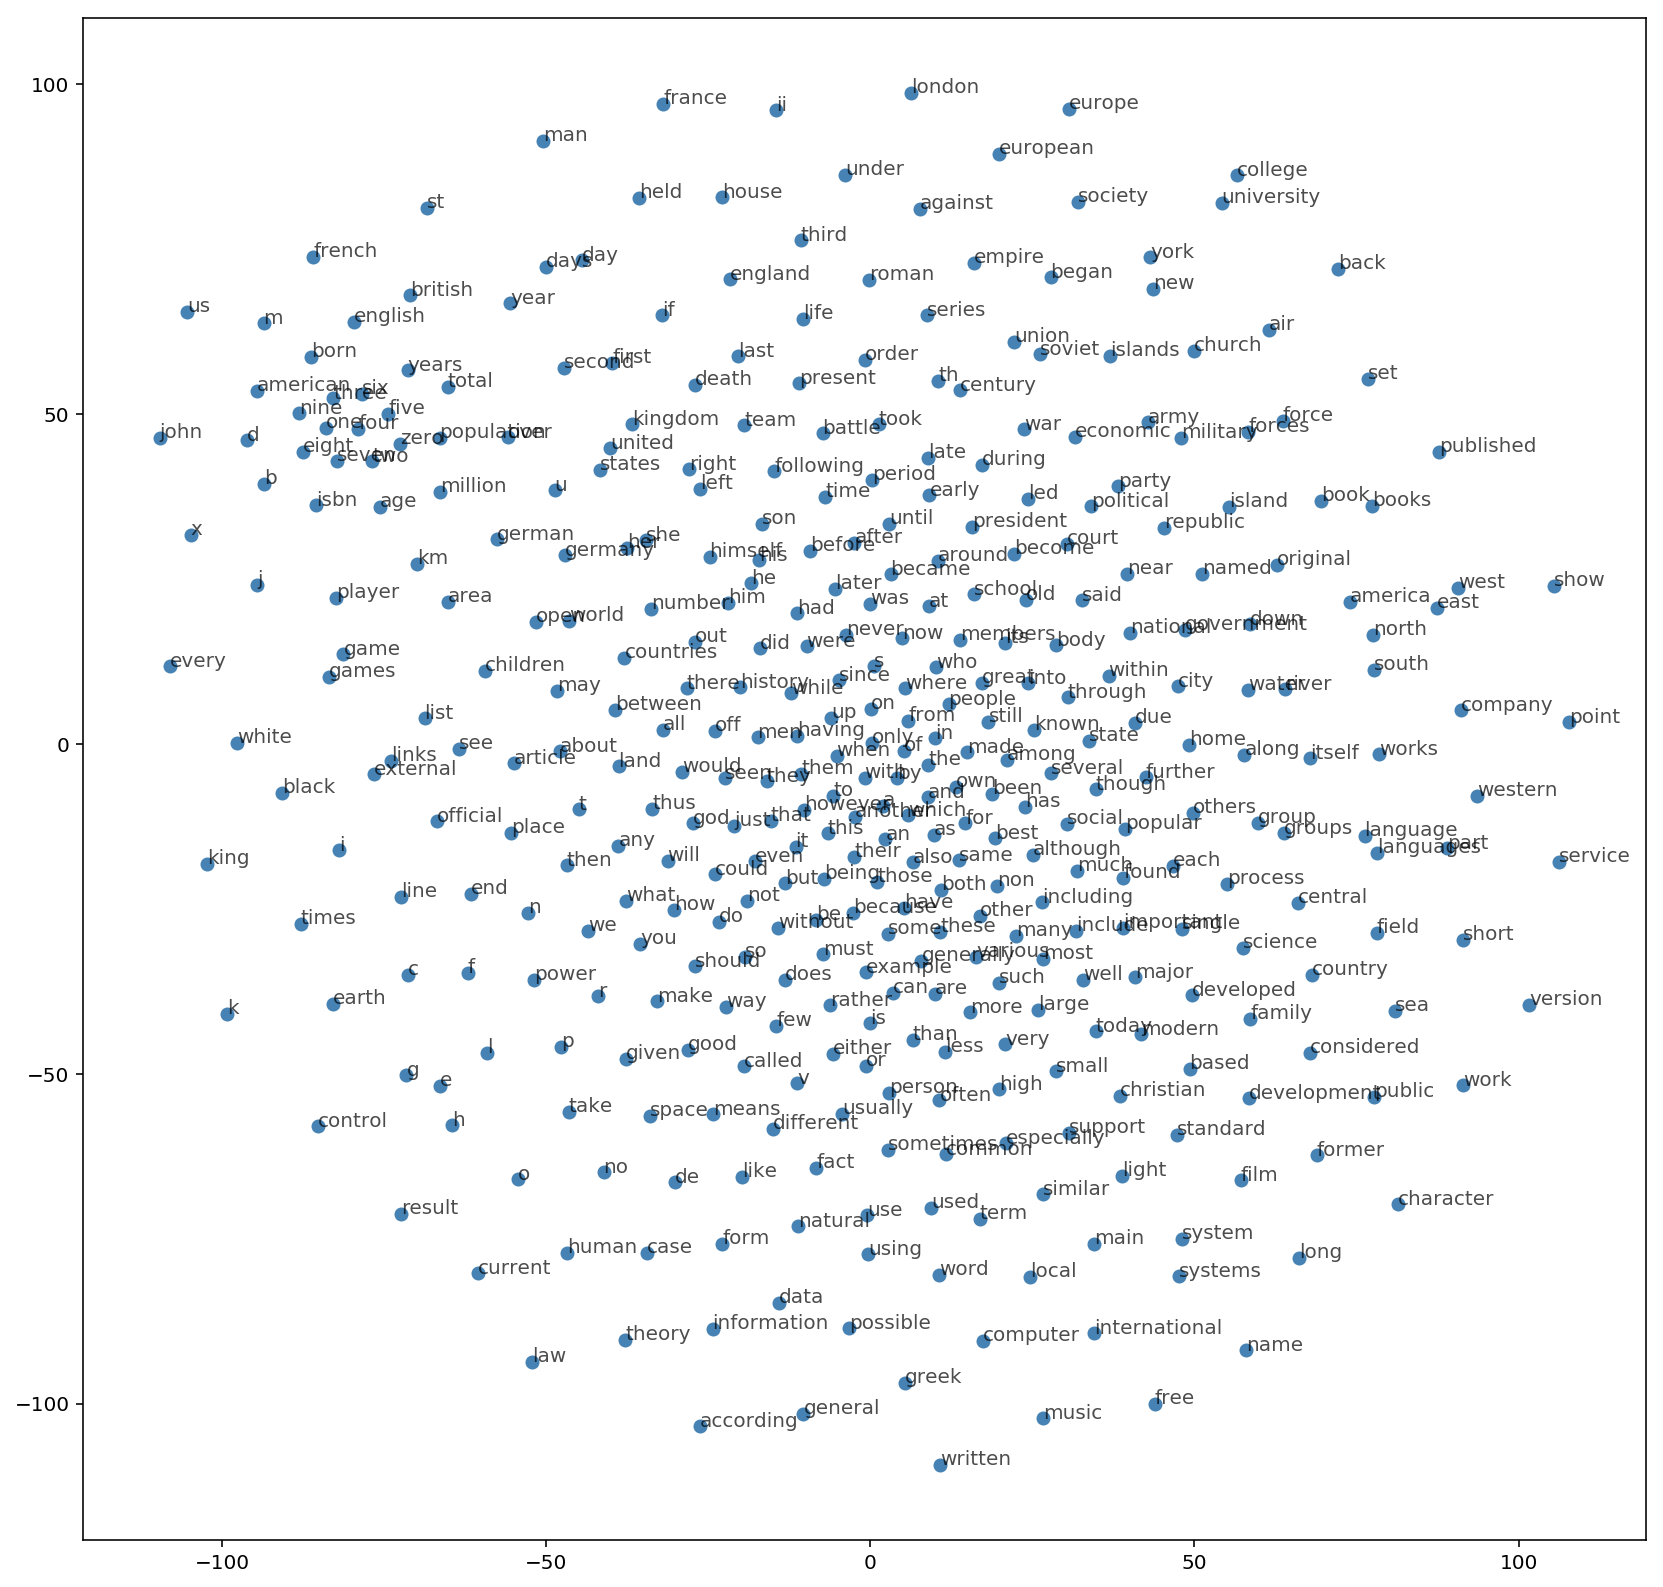

In [25]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)